In [22]:
q
#!pip install opencv-python mediapipe numpy xgboost pandas
!pip install scikit-learn



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from datetime import datetime
import csv

In [3]:
params = dict()
params["device"] = "cuda"
params["tree_method"] = "hist"

In [43]:


mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_draw = mp.solutions.drawing_utils

# Función para extraer landmarks como una lista plana
def extract_landmarks(landmarks):
    return np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks.landmark]).flatten()

# Abrir la cámara
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
# Archivo CSV donde se guardarán los landmarks y las etiquetas
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
label="mano derecha"
csv_filename = f"gestos/{label}_{dt_string}.csv"

# Intenta abrir el archivo existente, si no existe, crea uno nuevo con encabezados
try:
    csvfile = open(csv_filename, 'x', newline='')
    writer = csv.writer(csvfile)
    # Escribe los encabezados de columnas (0-20 landmarks * xyz = 63 columnas + 1 etiqueta)
    writer.writerow([f"lm_{i}_{axis}" for i in range(21) for axis in ['x', 'y', 'z']] + ['label'])
except FileExistsError:
    csvfile = open(csv_filename, 'a', newline='')
    writer = csv.writer(csvfile)

with hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            continue

        # Convertir la imagen de BGR a RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)

        # Dibujar los landmarks de las manos
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                # Extraer landmarks y aplanarlos para el CSV
                landmarks_list = extract_landmarks(hand_landmarks)
                # Aquí deberías definir cómo obtener la etiqueta, por ahora, se deja como 'unknown'
                writer.writerow(np.append(landmarks_list, label).tolist())

        cv2.imshow('MediaPipe Hands', image)
        if cv2.waitKey(5) &  0xFF == ord('q'):  # Salir con ESC
            break

cap.release()
cv2.destroyAllWindows()
csvfile.close()

# Entrenamiento del modelo XGBoost (debes tener el CSV con las etiquetas ya definidas)
df = pd.read_csv(csv_filename)


In [44]:
import pandas as pd
import glob
import os

# Define la ruta de la carpeta que contiene los archivos CSV
carpeta_gestos = 'gestos'

# Utiliza glob para listar todos los archivos CSV en la carpeta
archivos_csv = glob.glob(os.path.join(carpeta_gestos, '*.csv'))

# Lee cada archivo CSV y lo almacena en una lista
dfs = []
for archivo in archivos_csv:
    df = pd.read_csv(archivo)
    dfs.append(df)

# Concatena todos los DataFrames en la lista
concat_pd = pd.concat(dfs, axis=0)

# Guarda el DataFrame concatenado en un nuevo archivo CSV
concat_pd.to_csv("concat.csv", index=False)

concat_pd

,lm_0_x,lm_0_y,lm_0_z,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,...,lm_18_x,lm_18_y,lm_18_z,lm_19_x,lm_19_y,lm_19_z,lm_20_x,lm_20_y,lm_20_z,label
0,0.817837,0.877840,-4.080590e-07,0.756854,0.870539,0.017916,0.724248,0.817905,0.021863,0.699987,...,0.704170,0.684187,-0.032116,0.683970,0.718507,-0.030228,0.683644,0.756505,-0.028425,cuernitos
1,0.822269,0.882678,-4.175374e-07,0.757977,0.869977,0.024197,0.724274,0.817743,0.031476,0.698388,...,0.703115,0.684762,-0.026030,0.684609,0.721631,-0.022078,0.686871,0.762723,-0.018856,cuernitos
2,0.823944,0.888068,-4.111934e-07,0.759651,0.875151,0.021233,0.725309,0.822881,0.026749,0.698929,...,0.702503,0.691186,-0.028340,0.684765,0.728988,-0.025129,0.688068,0.770302,-0.021967,cuernitos
3,0.824188,0.895289,-4.066763e-07,0.757923,0.880915,0.018048,0.723821,0.828599,0.022093,0.697600,...,0.703081,0.699579,-0.029792,0.687093,0.738313,-0.027081,0.692201,0.779776,-0.023924,cuernitos
4,0.828070,0.897731,-4.092129e-07,0.761498,0.884699,0.021096,0.725877,0.830474,0.026126,0.698865,...,0.703395,0.700515,-0.029655,0.685827,0.738661,-0.026585,0.688925,0.779942,-0.023695,cuernitos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,0.479543,0.713818,2.336049e-07,0.416161,0.681028,-0.006451,0.368964,0.603200,-0.011917,0.338067,...,0.450935,0.429680,-0.070778,0.440714,0.372096,-0.080126,0.426021,0.321141,-0.087304,mano izquierda
793,0.440211,0.717559,3.814349e-07,0.378940,0.670499,-0.005524,0.340735,0.583450,-0.012884,0.316895,...,0.425855,0.442257,-0.086354,0.414410,0.387938,-0.098132,0.397069,0.344060,-0.106448,mano izquierda
794,0.435288,0.740889,4.316796e-07,0.370118,0.672625,-0.011256,0.335265,0.556341,-0.024467,0.312902,...,0.455769,0.506543,-0.119102,0.442878,0.457522,-0.131486,0.424983,0.416546,-0.140052,mano izquierda
795,0.476576,0.786723,2.661217e-07,0.413518,0.713119,-0.019787,0.374988,0.587890,-0.039018,0.348397,...,0.535233,0.585640,-0.158925,0.521148,0.547204,-0.175189,0.497237,0.514882,-0.184828,mano izquierda


In [45]:
concat_pd=pd.read_csv("concat.csv")
concat_pd

,lm_0_x,lm_0_y,lm_0_z,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,...,lm_18_x,lm_18_y,lm_18_z,lm_19_x,lm_19_y,lm_19_z,lm_20_x,lm_20_y,lm_20_z,label
0,0.817837,0.877840,-4.080590e-07,0.756854,0.870539,0.017916,0.724248,0.817905,0.021863,0.699987,...,0.704170,0.684187,-0.032116,0.683970,0.718507,-0.030228,0.683644,0.756505,-0.028425,cuernitos
1,0.822269,0.882678,-4.175374e-07,0.757977,0.869977,0.024197,0.724274,0.817743,0.031476,0.698388,...,0.703115,0.684762,-0.026030,0.684609,0.721631,-0.022078,0.686871,0.762723,-0.018856,cuernitos
2,0.823944,0.888068,-4.111934e-07,0.759651,0.875151,0.021233,0.725309,0.822881,0.026749,0.698929,...,0.702503,0.691186,-0.028340,0.684765,0.728988,-0.025129,0.688068,0.770302,-0.021967,cuernitos
3,0.824188,0.895289,-4.066763e-07,0.757923,0.880915,0.018048,0.723821,0.828599,0.022093,0.697600,...,0.703081,0.699579,-0.029792,0.687093,0.738313,-0.027081,0.692201,0.779776,-0.023924,cuernitos
4,0.828070,0.897731,-4.092129e-07,0.761498,0.884699,0.021096,0.725877,0.830474,0.026126,0.698865,...,0.703395,0.700515,-0.029655,0.685827,0.738661,-0.026585,0.688925,0.779942,-0.023695,cuernitos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13732,0.479543,0.713818,2.336049e-07,0.416161,0.681028,-0.006451,0.368964,0.603200,-0.011917,0.338067,...,0.450935,0.429680,-0.070778,0.440714,0.372096,-0.080126,0.426021,0.321141,-0.087304,mano izquierda
13733,0.440211,0.717559,3.814349e-07,0.378940,0.670499,-0.005524,0.340735,0.583450,-0.012884,0.316895,...,0.425855,0.442257,-0.086354,0.414410,0.387938,-0.098132,0.397069,0.344060,-0.106448,mano izquierda
13734,0.435288,0.740889,4.316796e-07,0.370118,0.672625,-0.011256,0.335265,0.556341,-0.024467,0.312902,...,0.455769,0.506543,-0.119102,0.442878,0.457522,-0.131486,0.424983,0.416546,-0.140052,mano izquierda
13735,0.476576,0.786723,2.661217e-07,0.413518,0.713119,-0.019787,0.374988,0.587890,-0.039018,0.348397,...,0.535233,0.585640,-0.158925,0.521148,0.547204,-0.175189,0.497237,0.514882,-0.184828,mano izquierda


In [ ]:
unique_important_features=['lm_18_z', 'lm_16_z', 'lm_12_y', 'lm_6_z', 'lm_0_x', 'lm_1_y', 'lm_10_z', 'lm_8_y', 'lm_19_y', 'lm_1_x', 'lm_18_y', 'lm_8_z', 'lm_7_z', 'lm_20_y', 'lm_16_y', 'lm_3_z', 'lm_17_z', 'lm_20_x', 'lm_4_y', 'lm_18_x', 'lm_4_x', 'lm_0_z', 'lm_6_y', 'lm_0_y', 'lm_5_z', 'lm_1_z', 'lm_11_y', 'lm_9_x', 'lm_14_z', 'lm_10_x', 'lm_16_x', 'lm_8_x']

[0]	train-mlogloss:1.70785	train-f1:0.64842	val-mlogloss:1.70996	val-f1:0.60809	test-mlogloss:1.70923	test-f1:0.64585
[1]	train-mlogloss:1.63525	train-f1:0.64917	val-mlogloss:1.63960	val-f1:0.60240	test-mlogloss:1.63789	test-f1:0.63762
[2]	train-mlogloss:1.56981	train-f1:0.67021	val-mlogloss:1.57622	val-f1:0.62744	test-mlogloss:1.57321	test-f1:0.66616
[3]	train-mlogloss:1.51180	train-f1:0.67135	val-mlogloss:1.51990	val-f1:0.63060	test-mlogloss:1.51544	test-f1:0.67704


E:\Programas\train_xgboost_mediapipe\lib\site-packages\xgboost\core.py:160: UserWarning: [12:01:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	train-mlogloss:1.45857	train-f1:0.68292	val-mlogloss:1.46827	val-f1:0.64203	test-mlogloss:1.46279	test-f1:0.68366
[5]	train-mlogloss:1.40971	train-f1:0.68395	val-mlogloss:1.42111	val-f1:0.63759	test-mlogloss:1.41410	test-f1:0.68710
[6]	train-mlogloss:1.36467	train-f1:0.68956	val-mlogloss:1.37731	val-f1:0.64507	test-mlogloss:1.36922	test-f1:0.68964
[7]	train-mlogloss:1.32196	train-f1:0.68911	val-mlogloss:1.33581	val-f1:0.64620	test-mlogloss:1.32635	test-f1:0.69159
[8]	train-mlogloss:1.28295	train-f1:0.69110	val-mlogloss:1.29809	val-f1:0.64833	test-mlogloss:1.28752	test-f1:0.69117
[9]	train-mlogloss:1.24557	train-f1:0.69269	val-mlogloss:1.26140	val-f1:0.65085	test-mlogloss:1.25025	test-f1:0.70055
[10]	train-mlogloss:1.21104	train-f1:0.70445	val-mlogloss:1.22777	val-f1:0.66279	test-mlogloss:1.21607	test-f1:0.71948
[11]	train-mlogloss:1.17823	train-f1:0.71234	val-mlogloss:1.19588	val-f1:0.67539	test-mlogloss:1.18318	test-f1:0.72869
[12]	train-mlogloss:1.14846	train-f1:0.71356	val-mlogl

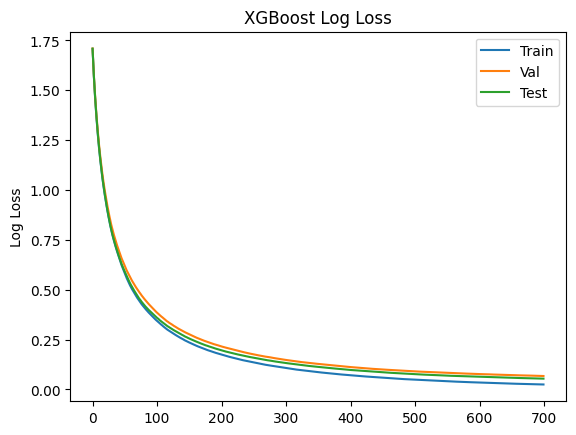

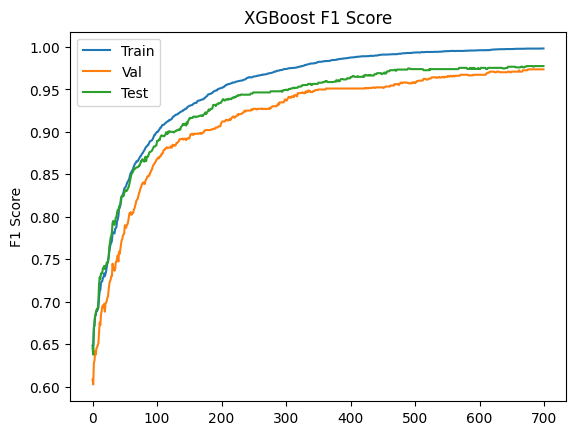

F1 Score: 0.9774464122407917


In [46]:
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
# Datos de ejemplo
X = concat_pd.drop('label', axis=1)
y = concat_pd['label']
X=X[unique_important_features]
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)  # 0.125 x 0.8 = 0.1

# Crear una instancia de LabelEncoder y transformar las etiquetas a valores numéricos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convertir datos a DMatrix, formato optimizado para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
dval = xgb.DMatrix(X_val, label=y_val_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

# Definir función de evaluación personalizada para F1 score
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    # Predicciones vienen como probabilidad de pertenencia a clases; necesitamos convertir a clases concretas
    preds = np.argmax(y_pred, axis=1)  # Convertir probabilidades a clases predichas
    # Calcular F1 score usando las etiquetas verdaderas y predicciones
    f1 = f1_score(y_true, preds, average='macro')
    # XGBoost espera retornar un nombre para la métrica y su valor. El segundo valor es 'True' si más alto es mejor.
    return 'f1', f1
# Parámetros para XGBoost
params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_train_encoded)),
    'eval_metric': 'mlogloss',  # métrica primaria para optimización
     'eta': 0.05,
    'tree_method': 'hist',  # Usa 'hist' que es compatible con la GPU
   # 'device': 'cuda',  # Especifica que se debe usar CUDA para el entrenamiento en GPU
   # 'predictor': 'gpu_predictor',

    'max_depth':3,  # Profundidad máxima de los árboles. Default es 6.
    'n_estimators': 50,
}

# Entrenar modelo con conjunto de validación y función de evaluación personalizada para F1
evals_result={}
evals = [(dtrain, 'train'), (dval, 'val'),(dtest, 'test')]
model = xgb.train(params, dtrain, num_boost_round=700, evals=evals,maximize=True, custom_metric=f1_eval, early_stopping_rounds=80, verbose_eval=True,evals_result=evals_result)

# Hacer predicciones en el conjunto de prueba
y_pred_probs = model.predict(dtest)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convertir las predicciones numéricas de vuelta a etiquetas categóricas
y_pred = label_encoder.inverse_transform(y_pred)

# Calcular y mostrar F1 score final en el conjunto de prueba
f1 = f1_score(y_test_encoded, np.argmax(y_pred_probs, axis=1), average='macro')

# Graficar los resultados

epochs = len(evals_result['train']['mlogloss'])
x_axis = range(0, epochs)

# Mlogloss
fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['mlogloss'], label='Train')
ax.plot(x_axis, evals_result['val']['mlogloss'], label='Val')
ax.plot(x_axis, evals_result['test']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# F1 Score
fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['f1'], label='Train')
ax.plot(x_axis, evals_result['val']['f1'], label='Val')
ax.plot(x_axis, evals_result['test']['f1'], label='Test')
ax.legend()
plt.ylabel('F1 Score')
plt.title('XGBoost F1 Score')
plt.show()
print(f"F1 Score: {f1}")


In [9]:
y_test

11210    mano izquierda
11204    mano izquierda
6385           victoria
9705       mano derecha
4375          dibujando
              ...      
3979          dibujando
2072          dibujando
2585          dibujando
11407    mano izquierda
2678          dibujando
Name: label, Length: 1170, dtype: object

In [14]:
import joblib
# Suponiendo que tu modelo entrenado se llama 'model'
model.save_model('modelo_entrenado.json')


# Suponiendo que tu LabelEncoder se llama 'label_encoder'
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

In [15]:
import xgboost as xgb
import joblib
# Cargar el modelo previamente guardado
model = xgb.Booster()
model.load_model('modelo_entrenado.json')


# Cargar el LabelEncoder previamente guardado
label_encoder = joblib.load('label_encoder.pkl')


C:\Users\Ignac\AppData\Local\Temp\ipykernel_10196\91579557.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes, rotation=45)
C:\Users\Ignac\AppData\Local\Temp\ipykernel_10196\91579557.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


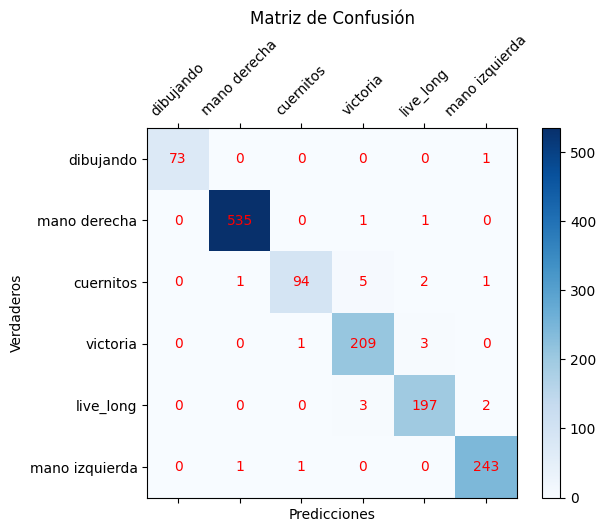


Reporte de Clasificación:
                precision    recall  f1-score   support

     dibujando       1.00      0.99      0.99        74
  mano derecha       1.00      1.00      1.00       537
     cuernitos       0.98      0.91      0.94       103
      victoria       0.96      0.98      0.97       213
     live_long       0.97      0.98      0.97       202
mano izquierda       0.98      0.99      0.99       245

      accuracy                           0.98      1374
     macro avg       0.98      0.97      0.98      1374
  weighted avg       0.98      0.98      0.98      1374



In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def report_without_threshold(y_true, y_pred_probs, classes):
    """
    Genera la matriz de confusión y el reporte de clasificación sin ajustar el umbral.
    """
    # Obtener la clase predicha basada en la probabilidad más alta
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Visualizar la matriz de confusión
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title('Matriz de Confusión')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + classes, rotation=45)
    ax.set_yticklabels([''] + classes)
    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Verdaderos')

    # Añadir los valores de la matriz en el gráfico
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')

    plt.show()

    # Calcular y mostrar el reporte de clasificación
    report = classification_report(y_true, y_pred, target_names=classes)
    print("\nReporte de Clasificación:")
    print(report)

# Asegúrate de que 'y_train.unique()' se evalúe correctamente para obtener los nombres de las clases
classes = list(y_test.unique())

# Llama a la función simplificada sin interactuar para ver si imprime correctamente
report_without_threshold(y_test_encoded, y_pred_probs, classes)


In [27]:
import time
import cv2
import mediapipe as mp
import numpy as np
import xgboost as xgb
import joblib
import pandas as pd
# Inicialización de MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

# Cargar el modelo XGBoost previamente entrenado como Booster
# model = xgb.Booster()
# model.load_model('modelo_entrenado.json')  # Asegúrate de que el nombre del archivo coincida
#
# # Cargar el LabelEncoder usado durante el entrenamiento
# label_encoder = joblib.load('label_encoder.pkl')  # Asegúrate de que el nombre del archivo coincida

# Función para extraer landmarks como una lista plana
def extract_landmarks_dataframe(landmarks):
    # Crear una lista con los nombres de las columnas
    columns = [f"lm_{i}_{axis}" for i in range(21) for axis in ['x', 'y', 'z']]
    # Extraer los valores de los landmarks
    values = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks.landmark]).flatten()
    # Crear y devolver un DataFrame con una sola fila y los nombres de columnas correctos
    return pd.DataFrame([values], columns=columns)

# Abrir la cámara
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 360)
with hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            continue
        prev_frame_time = time.time()
        labe_predict="nada"
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)

        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                # Utilizar la función modificada para extraer landmarks y convertirlos en un DataFrame
                landmarks_df = extract_landmarks_dataframe(hand_landmarks)

                # Ahora convertir el DataFrame a DMatrix
                dmatrix_data = xgb.DMatrix(landmarks_df[unique_important_features])

                # Hacer la predicción con el modelo
                y_pred_probs = model.predict(dmatrix_data)

                y_pred = np.argmax(y_pred_probs, axis=1)
                y_pred_label = label_encoder.inverse_transform(y_pred)

                labe_predict=y_pred_label[0]
        new_frame_time = time.time()
        fps_actual = 1 / (new_frame_time - prev_frame_time)
        fps_text = f'FPS: {fps_actual:.2f}'
        cv2.putText(image, labe_predict+" "+fps_text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow('MediaPipe Hands + XGBoost Prediction', image)
        if cv2.waitKey(5) &  0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


In [12]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y_%H_%M_%S")
print("date and time =", dt_string)

now = 2024-02-11 16:32:55.926528
date and time = 11/02/2024_16_32_55


In [23]:
# Asumiendo que 'model' es tu modelo entrenado con xgb.train()
feature_importances = model.get_score(importance_type='weight')
# Convertir las importancias a un formato de lista para ordenarlas
features = list(feature_importances.keys())
importances = list(feature_importances.values())

# Ordenar las características por importancia
sorted_indices = np.argsort(importances)[::-1]

# Seleccionar las 10 características más importantes
top_10_features = [features[idx] for idx in sorted_indices[:20]]

print("Las 10 características más importantes son:", top_10_features)

Las 10 características más importantes son: ['lm_0_z', 'lm_0_x', 'lm_4_x', 'lm_16_z', 'lm_16_y', 'lm_0_y', 'lm_12_y', 'lm_1_z', 'lm_14_z', 'lm_5_z', 'lm_8_x', 'lm_8_z', 'lm_4_y', 'lm_1_y', 'lm_20_y', 'lm_18_z', 'lm_10_z', 'lm_8_y', 'lm_20_x', 'lm_17_z']


In [24]:
import numpy as np

# Tipos de importancia
importance_types = ['weight', 'gain', 'cover']

# Lista para almacenar los top 20 features de cada tipo de importancia
all_important_features = []

for importance_type in importance_types:
    # Obtener importancias del modelo para el tipo actual
    feature_importances = model.get_score(importance_type=importance_type)
    features = list(feature_importances.keys())
    importances = list(feature_importances.values())

    # Ordenar las características por importancia
    sorted_indices = np.argsort(importances)[::-1]

    # Seleccionar los 20 features más importantes para el tipo actual
    top_20_features = [features[idx] for idx in sorted_indices[:20]]

    # Agregar estos features a la lista global
    all_important_features.extend(top_20_features)

# Eliminar duplicados
unique_important_features = list(set(all_important_features))

print("Características únicas seleccionadas (Top 20 por cada tipo de importancia, sin duplicados):")
print(unique_important_features)


Características únicas seleccionadas (Top 20 por cada tipo de importancia, sin duplicados):
['lm_18_z', 'lm_16_z', 'lm_12_y', 'lm_6_z', 'lm_0_x', 'lm_1_y', 'lm_10_z', 'lm_8_y', 'lm_19_y', 'lm_1_x', 'lm_18_y', 'lm_8_z', 'lm_7_z', 'lm_20_y', 'lm_16_y', 'lm_3_z', 'lm_17_z', 'lm_20_x', 'lm_4_y', 'lm_18_x', 'lm_4_x', 'lm_0_z', 'lm_6_y', 'lm_0_y', 'lm_5_z', 'lm_1_z', 'lm_11_y', 'lm_9_x', 'lm_14_z', 'lm_10_x', 'lm_16_x', 'lm_8_x']
